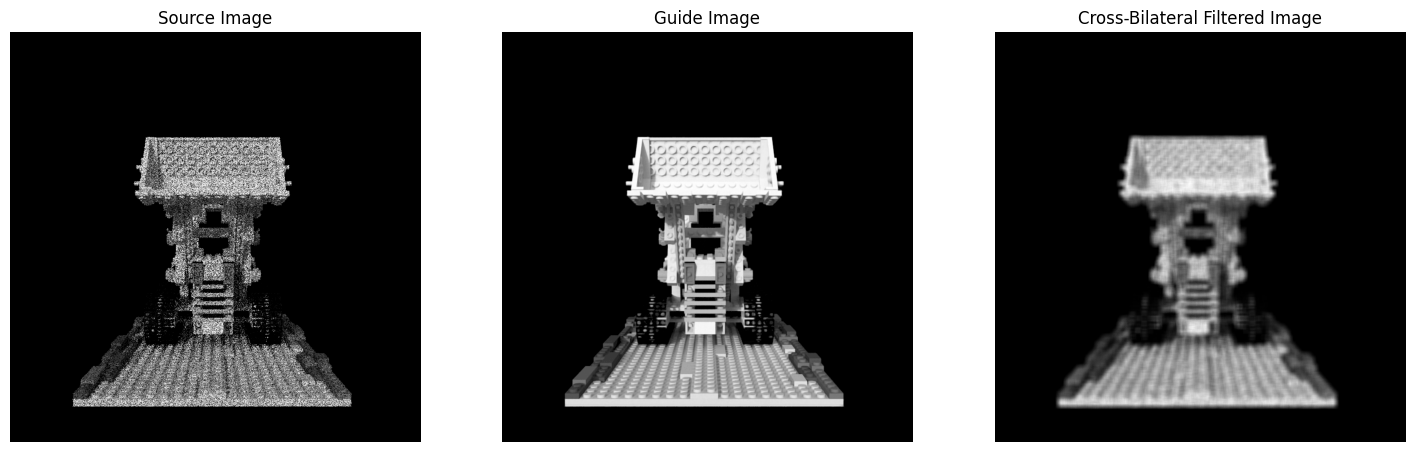

In [5]:
# gpt
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter


def cross_bilateral_filtering(src, guide, d, sigmaColor, sigmaSpace):
    h, w = src.shape[:2]
    filtered_image = np.zeros_like(src)
    
    # Gaussian spatial weights
    spatial_gaussian = np.fromfunction(
        lambda x, y: np.exp(-((x - d) ** 2 + (y - d) ** 2) / (2 * sigmaSpace ** 2)),
        (2 * d + 1, 2 * d + 1)
    )

    for i in range(h):
        for j in range(w):
            # Extract local region
            i_min, i_max = max(0, i - d), min(h, i + d + 1)
            j_min, j_max = max(0, j - d), min(w, j + d + 1)
            
            src_region = src[i_min:i_max, j_min:j_max]
            guide_region = guide[i_min:i_max, j_min:j_max]
            
            # Gaussian color weights
            color_gaussian = np.exp(-((guide_region - guide[i, j]) ** 2) / (2 * sigmaColor ** 2))
            
            # Combine spatial and color weights
            combined_weights = spatial_gaussian[(i_min - i + d):(i_max - i + d), (j_min - j + d):(j_max - j + d)] * color_gaussian
            
            # Normalize the weights
            normalized_weights = combined_weights / np.sum(combined_weights)
            
            # Apply the weights to the source region
            filtered_image[i, j] = np.sum(normalized_weights * src_region)
    
    return filtered_image

# 이미지를 읽어옵니다.
src_image = cv2.imread('/home/cglab/mitsuba3/results/source/lowref.png', cv2.IMREAD_GRAYSCALE)
guide_image = cv2.imread('/home/cglab/mitsuba3/results/source/final.png', cv2.IMREAD_GRAYSCALE)

# Cross-bilateral 필터 적용
filtered_image = cross_bilateral_filtering(src_image, guide_image, d=5, sigmaColor=25, sigmaSpace=16)

# 원본 이미지와 필터링된 이미지 출력
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title('Source Image')
plt.imshow(src_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Guide Image')
plt.imshow(guide_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Cross-Bilateral Filtered Image')
plt.imshow(filtered_image, cmap='gray')
plt.axis('off')

plt.show()

In [2]:
# https://github.com/Kohli25/Flash-NoFlash-Image-enhancement-Cross-Bilateral-filter/blob/main/Q2_201018.py
import cv2
import numpy as np
import matplotlib.pyplot as plt


def joint_bilt_filter(img,guideImg,w=5,sigma=(3, 0.1)):
    """
    2-D Joint bilateral filtering for grayscale images.

    Args:
        D (numpy.ndarray): Input grayscale image.
        C (numpy.ndarray): Guiding grayscale image.
        w (int): Half-size of the Gaussian bilateral filter window.
        sigma (tuple): Standard deviations for spatial and intensity domains.

    Returns:
        numpy.ndarray: Filtered image.
    """
    if img is None or not isinstance(img, np.ndarray) or img.dtype != np.float64 or img.min() < 0 or img.max() > 1:
        raise ValueError("Input image D must be a double precision matrix of size NxM on the closed interval [0,1].")

    if guideImg is None or not isinstance(guideImg, np.ndarray) or guideImg.dtype != np.float64 or guideImg.min() < 0 or guideImg.max() > 1:
        raise ValueError("Input image C must be a double precision matrix of size NxM on the closed interval [0,1].")

    w = int(w)
    sigma_d, sigma_r = sigma

    final= np.zeros_like(img)

    X, Y = np.meshgrid(np.arange(-w, w + 1), np.arange(-w, w + 1)) # window 안의 픽셀 위치
    G = np.exp(-(X**2 + Y**2) / (2 * sigma_d**2)) # gaussian

    dim =img.shape
    a = 0

    while a<dim[0]:
        b=0
        while b<dim[1]:
            iMin=max(a-w,0)
            iMax=min(a+w,dim[0]-1)
            jMin =max(b-w,0)
            jMax =min(b+ w,dim[1]-1)
            I=img[iMin:iMax+1,jMin:jMax+1]
            J=guideImg[iMin:iMax+1,jMin:jMax+1]
            H=np.exp(-((J - guideImg[a, b])**2) / (2 * sigma_r**2)) 
            F = H * G[iMin - a + w:iMax - a + w + 1, jMin - b + w:jMax - b + w + 1]
            final[a, b] = np.sum(F * I) / np.sum(F)
            b += 1
        a += 1

    return final


def joint_bil_2_color(N, F, w=5, sigma=(3, 0.1)):
    B = np.zeros_like(N)
    for channel in range(N.shape[2]):
        B[:, :, channel] = joint_bilt_filter(N[:, :, channel], F[:, :, channel], w, sigma)
    return B



def solution(image_path_a, image_path_b):

    path1=image_path_a
    path2=image_path_b

    input_image = cv2.imread(path1) / 255.0  # Normalize to [0, 1]
    input_image2 = cv2.imread(path2) / 255.0  # Normalize to [0, 1]

    image_N = np.copy(input_image)
    image_F = np.copy(input_image2)
    sigma1 = 3
    sigma2 = 0.2
    w = 11

    A_base= joint_bil_2_color(image_N, image_N, w=11, sigma=(3, 0.2))   

    A_nr=joint_bil_2_color(image_N, image_F, w=11, sigma=(3, 0.1))

    F_base=joint_bil_2_color(image_F, image_F, w=11, sigma=(3, 0.1))    

    eps = 0.02

    F_detail=(image_F.astype(np.float64) + eps) / (F_base.astype(np.float64) + eps)    


    # mask creation

    eps = 0.02
    T = -50  # Set your threshold value here
    i1=cv2.imread(path1)
    i2=cv2.imread(path2)

    if len(i1.shape) > 2:
        gA = cv2.cvtColor(i1, cv2.COLOR_BGR2GRAY).astype(np.float64)
        gF = cv2.cvtColor(i2, cv2.COLOR_BGR2GRAY).astype(np.float64)
    else:
        gA = i1.astype(np.float64)
        gF = i2.astype(np.float64)


    diff=gF-gA; 
    mf = np.zeros_like(diff)
    ms = np.zeros_like(diff)  # Initialize shadow mask
    # Initialize shadow mask

    # Detect shadow where difference is less than or equal to threshold T
    mf[diff <= -50] = 1

    ms[gF / np.max(gF) > 0.95] = 1  # Detect specularities

    M = np.zeros_like(i1)  # Mask initialization
    se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4, 4))  # Structuring element

    for i in range(i1.shape[2]):  # Build the flash mask
        m = np.logical_or(mf, ms).astype(np.uint8)  # Merge two masks
        m=m*255
        M[:, :, i] = cv2.dilate(m, se)

    M=M/255
    
    
    out = ((1 - M) * A_nr * F_detail + M * A_base)

    
    return out

# sol = solution('/home/cglab/mitsuba3/results/lowref0_800res_sourceiter_0.03lr.png','/home/cglab/mitsuba3/results/final0_800res_2000iter_0.03lr.png')
sol = solution('/home/cglab/mitsuba3/results/flash/cakeNo-flash.','/home/cglab/mitsuba3/results/flash/cbf_flash.png')


In [3]:


cv2.imshow('Image', sol)
cv2.waitKey(0)  # 키 입력이 있을 때까지 창을 유지
cv2.destroyAllWindows()

In [1]:
# https://github.com/CharalambosIoannou/Image-Processing-Joint-Bilateral-Filter/blob/master/jointbilatFil.py
import numpy as np
import cv2
import math

def gauss(img,spatialKern, rangeKern):    
    gaussianSpatial = 1 / math.sqrt(2*math.pi* (spatialKern**2)) #gaussian function to calcualte the spacial kernel ( the first part 1/sigma * sqrt(2π))
    gaussianRange= 1 / math.sqrt(2*math.pi* (rangeKern**2)) #gaussian function to calcualte the range kernel
    matrix = np.exp(-np.arange(256) * np.arange(256) * gaussianRange)
    xx=-spatialKern + np.arange(2 * spatialKern + 1)
    yy=-spatialKern + np.arange(2 * spatialKern + 1)
    x, y = np.meshgrid(xx , yy )
    #calculate spatial kernel from the gaussian function. That is the gaussianSpatial variable multiplied with e to the power of (-x^2 + y^2 / 2*sigma^2) 
    spatialGS = gaussianSpatial*np.exp(-(x **2 + y **2) /(2 * (gaussianSpatial**2) ) ) 
    return matrix,spatialGS


def padImage(img,spatialKern): #pad array with mirror reflections of itself.
    img=np.pad(img, ((spatialKern, spatialKern), (spatialKern, spatialKern), (0, 0)), 'symmetric')
    return img

    
def jointBilateralFilter(img, img1,spatialKern, rangeKern):
    h, w, ch = img.shape #get the height,width and channel of the image with no flash
    orgImg = padImage(img,spatialKern) #pad image with no flash
    secondImg = padImage(img1,spatialKern)   #pad image with flash  
    matrix,spatialGS=gauss(img,spatialKern, rangeKern) #apply gaussian function

    outputImg = np.zeros((h,w,ch), np.uint8) #create a matrix the size of the image
    summ=1
    for x in range(spatialKern, spatialKern + h):
        for y in range(spatialKern, spatialKern + w):
            for i in range (0,ch): #iterate through the image's height, width and channel
                #apply the equation that is mentioned in the pdf file
                neighbourhood=secondImg[x-spatialKern : x+spatialKern+1 , y-spatialKern : y+spatialKern+1, i] #get neighbourhood of pixels
                central=secondImg[x, y, i] #get central pixel
                res = matrix[ abs(neighbourhood - central) ]  # subtract them                   
                summ=summ*res*spatialGS #multiply them with the spatial kernel
                norm = np.sum(res) #normalization term
                outputImg[x-spatialKern, y-spatialKern, i]= np.sum(res*orgImg[x-spatialKern : x+spatialKern+1, y-spatialKern : y+spatialKern+1, i]) / norm # apply full equation of JBF(img,img1)
    return outputImg



spatialKern = 30 #27
rangeKern =20  #10
image = cv2.imread('/home/cglab/mitsuba3/results/source/lowref.png')
img1=cv2.imread('/home/cglab/mitsuba3/results/source/final.png') #read both images, flash and no flash image
filteredimg = jointBilateralFilter(image, img1, spatialKern, rangeKern)
cv2.imshow('input', image) #show original no flash image
cv2.imshow('JointBilateralFilter',filteredimg ) #show image after joint bilateral filter is applied

: 

In [10]:
#Works
import numpy as np
import cv2
import math
from tqdm import tqdm 


def distance(x, y, i, j):
    return np.sqrt((x-i)**2 + (y-j)**2)

def gaussian(x, sigma):
    return (1.0 / (np.sqrt(2*math.pi)*sigma)) * np.exp(-0.5*(x/sigma)**2)

def joint_bilateral_filter(src, guide, diameter, sigma_color, sigma_space):
    print('===============START=================')
    new_image = np.zeros(src.shape)
    radius = diameter/2
    n = len(src)
    m = len(src[0])
    for x in tqdm(range(0, n)):
        for y in range(m):
            curr_pixel = 0
            denom = 0
            # kernel
            for q in range(diameter):
                for s in range(diameter):
                    value_x = x - (radius - s)
                    value_y = y - (radius - q)
                    if value_x >= n:
                        value_x -= n
                    if value_y >= m:
                        value_y -= m
                    #print(value_x, value_y, x, y)
                    g_color = gaussian(guide[int(value_x)][int(value_y)] - guide[x][y], sigma_color)  # source becomes guide
                    g_space = gaussian(distance(value_x, value_y, x, y), sigma_space)
                    weight = g_color*g_space
                    curr_pixel += src[int(value_x)][int(value_y)] * weight
                    denom += weight

            curr_pixel = curr_pixel/denom
            new_image[x][y] = np.rint(curr_pixel)
    print('===============FINISH=================')
    return new_image



# img = cv2.imread('/home/cglab/mitsuba3/results/flash/cakeNo-flash.jpg')
# img2 = cv2.imread('/home/cglab/mitsuba3/results/flash/cakeFlash.jpg')

image = cv2.imread('/home/cglab/mitsuba3/results/source/lowref.png')
img2 = cv2.imread('/home/cglab/mitsuba3/results/source/final.png')

# for i in range(10, 30, 4):
#     for j in range(1, 30, 5):
#         for k in range(1, 30, 5):

i,j,k=14,40,40
file_name_string = "diameter-" + str(i) + "_sigmaColor-" + str(j) + "_sigmaSpace-" + str(k) + ".png"
jbf_image = joint_bilateral_filter(image, img2, i, j, k)
cv2.imwrite("./results/jbf_code/"+file_name_string, jbf_image)

    
print('================================================WHOLE PROGRAM DONE=================================================')

===============START=================


100%|██████████| 800/800 [34:54<00:00,  2.62s/it]

===============FINISH=================
================================================WHOLE PROGRAM DONE=================================================


In [7]:
#Works
import cv2

# image = cv2.imread('/home/cglab/mitsuba3/results/flash/cakeNo-flash.jpg')
# guide_image = cv2.imread('/home/cglab/mitsuba3/results/flash/cakeFlash.jpg')
# 
image = cv2.imread('/home/cglab/mitsuba3/results/source/lowref_32spp.png')
guide_image = cv2.imread('/home/cglab/mitsuba3/results/source/final.png')


diameter = -1
sig_color=40
sig_space=40
jbf=cv2.ximgproc.jointBilateralFilter(guide_image,image, diameter, sig_color, sig_space)
cv2.imshow('jbf', jbf)
cv2.waitKey(0)  # 키 입력이 있을 때까지 창을 유지
cv2.destroyAllWindows()

# bf=cv2.bilateralFilter(image, -1, 80, 200)
# cv2.imshow('bf', bf)
# cv2.waitKey(0)  # 키 입력이 있을 때까지 창을 유지
# cv2.destroyAllWindows()
file_name_string = "diameter-" + str(diameter) + "_sigmaColor-" + str(sig_color) + "_sigmaSpace-" + str(sig_space) + ".png"
cv2.imwrite("./results/jbf_cv2/"+file_name_string, jbf)

True